In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import pickle

from utils.util import read_yaml
from box import Box

from utils.eda_tools import select_good_period, single_column_vis
import warnings
warnings.filterwarnings('ignore')

#### Load Data

In [9]:
cfg = Box(read_yaml('../src/conf/config.yaml'))
Config = Box(read_yaml('../src/conf/baseline.yaml'))

In [3]:
# df = pd.read_csv(Config.data.raw_file_path, index_col=0, parse_dates=[0])

# selected_tags = pd.read_csv(Config.data.output_selected_tag_path, index_col=0)
# selected_tags = selected_tags[~selected_tags.Tags.isin(Config.preprocessing.remove_unwanted_cv.parameters.columns)]

# ctrl_tag = list(selected_tags.query('Control=="Yes"').Tags.values)
# ind_tag = list(selected_tags.query('Control!="Yes"').Tags.values)

# df = df[ctrl_tag+ind_tag+[Config.target]]

# # Remove Shutdown
# df = df.query(f'`{Config.preprocessing.remove_shutdown_period.parameters.column}`{Config.preprocessing.remove_shutdown_period.parameters.operator}{Config.preprocessing.remove_shutdown_period.parameters.threshold}')

In [3]:
df_path = cfg.path.processed_data
df = pd.read_csv(df_path, parse_dates=['Timestamp'], index_col=0)

In [4]:
# move the target variable to the first of the dataframe
df = df[[cfg.target_variable] + [col for col in df.columns if col != cfg.target_variable]]
# select the rows in df where the target variable is larger than 100
df = df[df[cfg.target_variable] > 100]
df.shape

(22816, 1912)

In [5]:
selected_tags = pd.read_csv(cfg.path.v2.selected_tags)
selected_tags.head()

,Tags,Full Tags,Assets1,Assets,Locn,Location,Column1,Property,Description,Units,Digital (States)\n
0,311FC018.MEAS,3P1101_2:311FC018.MEAS,3P1101_2,3P1101,3-1100,Acid Gas Removal Unit,fc,MEAS,P1101A MIN FLOW,T/D,
1,311LC013.MEAS,3V1104_2:311LC013.MEAS,3V1104_2,3V1104,3-1100,Acid Gas Removal Unit,lc,MEAS,V1104 AMINE FLASH DRUM,%,
2,311PC017.MEAS,3V1102_2:311PC017.MEAS,3V1102_2,3V1102,3-1100,Acid Gas Removal Unit,pc,MEAS,V1102 GAS OUTLET TO ATM,BAR G,
3,342LC116.MEAS,3E4201_2:342LC116.MEAS,3E4201_2,3E4201,3-4200,Cooling Water System,lc,MEAS,A4201 CW BASIN,%,
4,312FC001.MEAS,3F1211_2:312FC001.MEAS,3F1211_2,3F1211,3-1200,Dehydration Unit,fc,MEAS,F1211 REGEN CIRCUIT FLOW,T/D,


In [7]:
ctrl_tag = selected_tags['Tags'][:cfg.num_selected_cvs.v2].tolist()
print(len(ctrl_tag))
ind_tag = selected_tags['Tags'][cfg.num_selected_cvs.v2:].tolist()
len(ind_tag)

21


530

In [5]:
#select_good_period(df, 10)

In [7]:
# # Investigate in all the CV
# for tag in ctrl_tag:
#     fig = single_column_vis(df, tag, '')
#     fig.show()

#### Build the Final Model / Feature Selection Verification

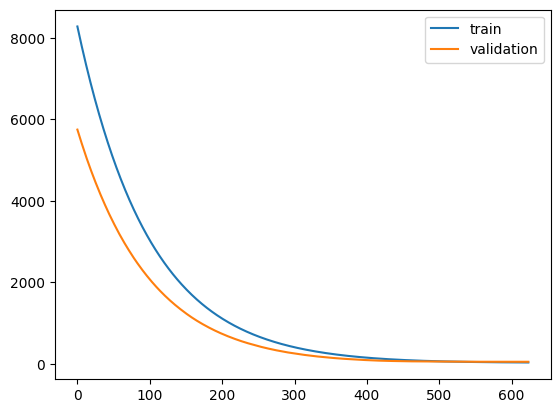

In [8]:
my_model = XGBRegressor(**Config.xgboost_regressor_config.model_config)

X = df[ctrl_tag+ind_tag]
y = df[Config.target]

train_data, test_data, train_target, test_target = train_test_split(X, y, **Config.xgboost_regressor_config.train_config)

my_model.fit(train_data, train_target, 
             eval_set=[(train_data, train_target),(test_data, test_target)], verbose=False)

results = my_model.evals_result()

# plot learning curves
plt.plot(results['validation_0']['rmse'], label='train')
plt.plot(results['validation_1']['rmse'], label='validation')
# show the legend
plt.legend()
# show the plot
plt.show()

In [10]:
# print the rmse for the train and test sets
print("Train RMSE: %.2f" % (results['validation_0']['rmse'][-1]))
print("Test RMSE: %.2f" % (results['validation_1']['rmse'][-1]))
# # print the r^2 for the train and test sets
# print("Train R2: %.2f" % (results['validation_0']['r2'][-1]))
# print("Test R2: %.2f" % (results['validation_1']['r2'][-1]))

Train RMSE: 38.58
Test RMSE: 55.84


In [12]:
# save
pickle.dump(my_model, open(Config.xgboost_regressor_config.v2_model_path, "wb"))

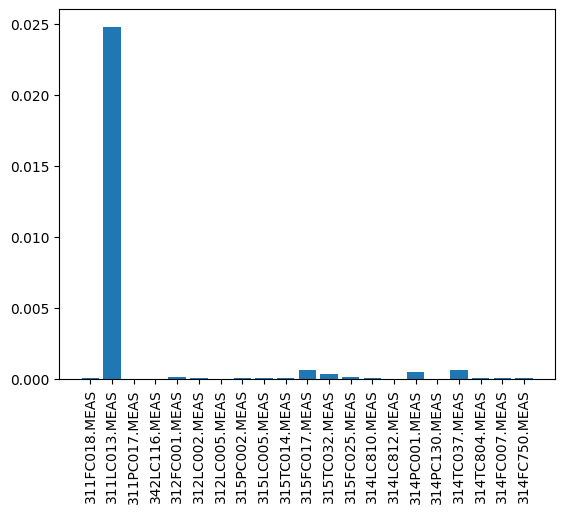

In [13]:
# load the model
loaded_model = pickle.load(open(Config.xgboost_regressor_config.v2_model_path, "rb"))
# get the feature importance for ctrl_tag
importance = loaded_model.feature_importances_[:len(ctrl_tag)]
# plot feature importance, add names
plt.bar([x for x in range(len(importance))], importance)
plt.xticks([x for x in range(len(importance))], ctrl_tag, rotation='vertical')
plt.show()

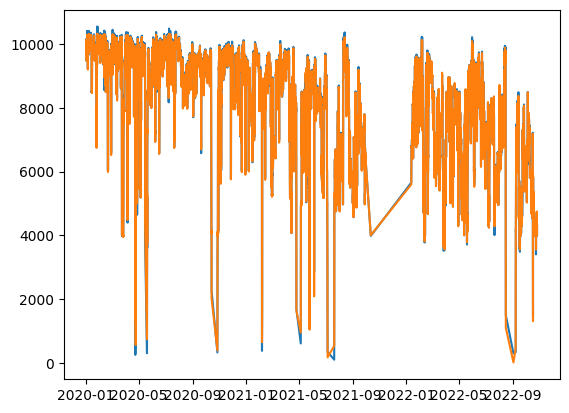

In [14]:
plt.plot(train_data.index, train_target)
plt.plot(train_data.index, my_model.predict(train_data))

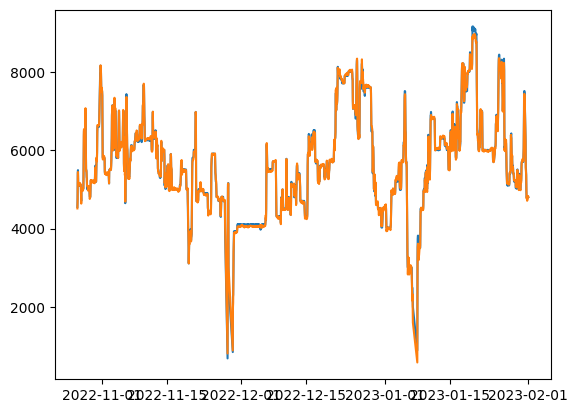

In [15]:
plt.plot(test_data.index, test_target)
plt.plot(test_data.index, my_model.predict(test_data))

#### Optimization

In [19]:
from tqdm.notebook import tqdm_notebook

from utils.util import read_json, read_pickle, write_json
from utils.eda_tools import single_column_vis, lines_plot
from utils.optimization_result_vis import Controllable_Value_Plot

from optimization.Features import Feature_Info, get_feature_full_name
from optimization.Data import IncomingData, Missing_info
from optimization.Bounds import Bounds
from optimization.Dual_Annealing_Optimization import Dual_Annealing_Optimization

In [38]:
ctrl_tag_length = len(ctrl_tag)
difference_quantile = (df.iloc[:, :ctrl_tag_length].shift(1)-df.iloc[:, :ctrl_tag_length]).quantile(0.95)

mean_of_controllable = df.iloc[:, :ctrl_tag_length].mean()

ctrl_change_rate = (difference_quantile/mean_of_controllable).values

# Upper and Lower bounds historically, which directives can never exceed
quantile_lower = [df[tag].quantile(0.05) for tag in ctrl_tag]
quantile_upper = [df[tag].quantile(0.95) for tag in ctrl_tag]
bounds = [list(bound) for bound in zip(quantile_lower, quantile_upper)]

cont_dict = {tag:{'max_rate': rate,'bounds':bound} for tag,rate,bound in zip(ctrl_tag, ctrl_change_rate, bounds)}

# generate optimizer.json
opt_dict = dict()
opt_dict['controllable'] = cont_dict
opt_dict['noncontrollable'] = [tag for tag in ind_tag]

opt_dict['kwargs'] = {'maxiter': 10}

In [39]:
test_df = df[ctrl_tag+ind_tag].loc['2022-01-01':]

In [40]:
test_df.columns = [column+'___Value' for column in test_df.columns]

features = Feature_Info(opt_dict)
incoming_data = IncomingData(test_df, features)

# bounds = Bounds(incoming_data).final_bounds()
bounds = [tuple(bound) for bound in zip(quantile_lower, quantile_upper)]

Optimization = Dual_Annealing_Optimization(incoming_data, my_model)

In [41]:
nrows = incoming_data.value.shape[0]
optimal_controls = [None] * nrows
optimized_final_product = [None] * nrows

for i in tqdm_notebook(range(nrows)):
    timestamp = incoming_data.value.index[i]
    #bound = bounds[i]
    bound = bounds
    
    optimal_controls_vals, optimized_product = Optimization.run_optimization(timestamp, bound)
    optimal_controls[i] = optimal_controls_vals
    optimized_final_product[i] = optimized_product

  0%|          | 0/8617 [00:00<?, ?it/s]

In [45]:
test_df.columns = [column.replace('___Value', '') for column in test_df.columns]

In [46]:
result_df = pd.DataFrame(optimal_controls, columns=[tag + '_Optimized' for tag in ctrl_tag], index=test_df.index[:nrows])
result_df['LNG_optimized'] = np.array(optimized_final_product).flatten()
result_df['LNG_before_optimized'] = (my_model.predict(test_df[ctrl_tag+ind_tag]))

In [47]:
test_df.shape, result_df.shape

((8617, 551), (8617, 23))

In [67]:
final_df = pd.merge(result_df, test_df, left_index=True, right_index=True) # 23(21 cvs + 2 LNG) columns of the result_df + 551 columns of the test_df

In [69]:
Controllables_number_in_one_plot = 7

In [70]:
for i in range(len(ctrl_tag)//7):
    Controllable_Value_Plot(final_df, ctrl_tag[Controllables_number_in_one_plot*i:Controllables_number_in_one_plot*(i+1)]).write_html(Config.result_generating.v2.visualization.controllable_result_path[i])

In [76]:
# for i in range(len(ctrl_tag)//7, len(ctrl_tag)//7+1):
#     Controllable_Value_Plot(final_df, ctrl_tag[Controllables_number_in_one_plot*i:]).write_html(Config.result_generating.visualization.controllable_result_path[i])

In [78]:
updated_df = pd.read_csv(cfg.path.all_product_result, index_col=0, parse_dates=[0]) # provided
updated_df[['LNG_before_optimized','LNG_optimized']] = final_df[['LNG_before_optimized', 'LNG_optimized']]

In [79]:
scalar = np.random.normal(loc=0.6,scale=0.1 ,size = updated_df.shape[0])

updated_df['final_LNG_optimized'] = np.where((updated_df['LNG_optimized']-updated_df['LNG_before_optimized'])>scalar*updated_df['Delta'], scalar*updated_df['Delta']+updated_df['LNG_before_optimized'],updated_df['LNG_optimized'])
final_df['LNG_optimized'] = updated_df['final_LNG_optimized']

In [86]:
df_graph = pd.DataFrame()
df_graph['Actual LNG Level'] = updated_df['LNG_before_optimized']
df_graph['Optimized LNG Level'] = updated_df['final_LNG_optimized']
df_graph['Predicted LNG Level'] = df[Config.target].loc['2022-01-01':]

lines_plot(df_graph, ['Actual LNG Level', 'Optimized LNG Level', 'Predicted LNG Level']).write_html(Config.result_generating.v2.visualization.optimized_target_level_path)

In [66]:
# Only the final_LNG_optimized column is updatd, client's demand

updated_df.iloc[: , :-1].to_csv(Config.result_generating.v2.outputing.all_product_output_path)

In [ ]:
from utils.optimization_result_vis import find_nearest_point

# Client's demand, for each time stamp, we use euclidean_dist algorithm to find the most similar point in the training data

TRAINING_TESTING_CUTOFF_DATE = '2022-01-01'

result = pd.DataFrame()
for i in range(final_df.shape[0]):
    temp = find_nearest_point(final_df.iloc[[i],:], df, ctrl_tag, TRAINING_TESTING_CUTOFF_DATE)
    result = pd.concat([result, temp])
result.index = final_df.index

In [92]:
result = result.drop(columns=['Euclidean_Dist_Validation1', 'Euclidean_Dist_Validation2','Euclidean_Dist_Validation3','Euclidean_Dist_Validation4'])

In [93]:
final_df = pd.concat([final_df, result], axis=1)
'''
final_df:
23(21 cvs + 1*2 LNG) columns of the result_df (optimized result)
+ 
197 columns of the test_df (original data, cvs + non-cvs)
+
84 (21 * 4) columns of the validation result for each cv
+
4 (1 * 4) columns of the validation timestamp (most similar timestamp to the current timestamp in terms of the 21 cvs) for the whole 21 cvs
'''

In [95]:
final_df.to_csv(Config.result_generating.v2.outputing.output_path)

#### Validation

In [8]:
final_df = pd.read_csv(Config.result_generating.v2.outputing.output_path, index_col=0, parse_dates=[0])
final_df.shape

(8492, 308)

In [9]:
train_df = df[ctrl_tag].loc[:'2022-01-01']
train_df.shape

(14199, 21)

In [10]:
test_df = df[ctrl_tag].loc['2022-01-01':]
test_df.shape

(8617, 21)

In [12]:
# analyze the missing value of train_df
test_df.isnull().sum()

311FC020.MEAS        0
311FRQ003.MEAS       0
311PC017.MEAS        0
342LC116.MEAS        0
312PC010.MEAS        0
315TC003.MEAS        0
315FC013.MEAS        0
315FC021.MEAS      122
315FC025.MEAS        3
314TC001.MEAS        0
314FQ011.MEAS        0
314PDC037.MEAS       1
314TC044.MEAS        0
314FC001.MEAS        0
314TDC166.MEAS       0
314PDC863A.MEAS      0
314LC911.MEAS        0
314FC007.MEAS        0
314FC141.MEAS        0
314FC750.MEAS        0
314PC108.MEAS        0
dtype: int64

In [13]:
from utils.optimization_result_vis import generate_validation_result

new_final_df = generate_validation_result(final_df, df, ctrl_tag, '2022-01-01')
new_final_df

,311FC020.MEAS_Optimized,311FRQ003.MEAS_Optimized,311PC017.MEAS_Optimized,342LC116.MEAS_Optimized,312PC010.MEAS_Optimized,315TC003.MEAS_Optimized,315FC013.MEAS_Optimized,315FC021.MEAS_Optimized,315FC025.MEAS_Optimized,314TC001.MEAS_Optimized,...,314FC750.MEAS_Validation3,314FC750.MEAS_Validation4,314PC108.MEAS_Validation1,314PC108.MEAS_Validation2,314PC108.MEAS_Validation3,314PC108.MEAS_Validation4,Nearest_TimeStamp_Validation1,Nearest_TimeStamp_Validation2,Nearest_TimeStamp_Validation3,Nearest_TimeStamp_Validation4
Timestamp,,,,,,,,,,,,,,,,,,,,,
2022-01-12 16:00:00,4282.946387,10943.625149,0.603691,78.008892,15.361737,21.369806,7.879158,-0.437265,544.985287,22.589994,...,0.307904,0.287075,4.149902,4.149902,4.149902,4.149902,2021-06-20 16:00:00,2021-06-18 12:00:00,2021-06-20 14:00:00,2021-06-18 11:00:00
2022-01-12 21:00:00,3774.899410,10856.509674,0.653728,80.208462,15.112136,37.755522,6.425732,-4.655065,751.717596,22.137625,...,0.214627,0.21191,4.149902,4.149902,4.149902,4.149902,2020-09-13 10:00:00,2020-09-13 11:00:00,2020-09-13 17:00:00,2020-09-13 12:00:00
2022-01-12 22:00:00,1257.256840,10956.905294,0.671124,76.006799,15.565671,29.527769,25.175922,-0.542076,361.135671,21.774963,...,0.201043,0.201949,4.149902,4.149902,4.149902,4.149902,2021-04-09 02:00:00,2021-04-09 03:00:00,2021-04-09 01:00:00,2021-04-09 00:00:00
2022-01-13 00:00:00,885.599926,11146.253639,0.605013,84.265507,15.010350,24.025171,16.466044,-0.096853,265.956800,21.219093,...,0.222777,0.224589,4.149902,4.149902,4.149902,4.149902,2020-08-19 11:00:00,2021-07-30 16:00:00,2021-07-30 21:00:00,2021-07-31 00:00:00
2022-01-13 10:00:00,918.927326,11097.867497,0.652897,74.837024,15.663926,37.110404,27.902250,-3.976316,843.536621,22.495626,...,0.215533,0.2264,4.149902,4.149902,4.149902,4.149902,2021-04-18 06:00:00,2021-04-18 12:00:00,2021-04-06 00:00:00,2021-04-05 17:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-31 20:00:00,2264.236017,11027.997880,0.643202,76.903345,16.127563,26.240730,16.535286,-0.268281,727.343314,22.348219,...,0.268057,0.278924,4.149902,4.149902,4.149902,4.149902,2021-06-17 09:00:00,2021-06-19 22:00:00,2021-06-14 06:00:00,2021-06-21 00:00:00
2023-01-31 21:00:00,4649.219712,11031.973745,0.646208,76.167470,15.246506,22.054648,24.848810,-4.112266,665.758200,21.655594,...,0.194704,0.193798,4.149902,4.149902,4.149902,4.149902,2020-09-20 05:00:00,2021-03-11 09:00:00,2020-09-20 04:00:00,2021-03-14 01:00:00
2023-01-31 22:00:00,4104.383093,11034.982474,0.650825,78.062465,15.360823,25.463249,1.424966,-5.053793,925.004053,21.264960,...,0.206477,0.215533,4.149902,4.149902,4.149902,4.149902,2020-09-14 11:00:00,2020-09-14 12:00:00,2020-09-14 20:00:00,2020-09-16 06:00:00


In [25]:
# use the updated function in Jupyter notebook without restarting the kernel
import importlib
import utils.optimization_result_vis  # import the module

importlib.reload(utils.optimization_result_vis)  # reload the module

res = utils.optimization_result_vis.generate_validation_result(final_df, df, ctrl_tag, '2022-01-01')

In [26]:
res.head()

,311FC020.MEAS_Validation1,311FC020.MEAS_Validation2,311FC020.MEAS_Validation3,311FC020.MEAS_Validation4,311FRQ003.MEAS_Validation1,311FRQ003.MEAS_Validation2,311FRQ003.MEAS_Validation3,311FRQ003.MEAS_Validation4,311PC017.MEAS_Validation1,311PC017.MEAS_Validation2,...,314FC750.MEAS_Validation3,314FC750.MEAS_Validation4,314PC108.MEAS_Validation1,314PC108.MEAS_Validation2,314PC108.MEAS_Validation3,314PC108.MEAS_Validation4,Nearest_TimeStamp_Validation1,Nearest_TimeStamp_Validation2,Nearest_TimeStamp_Validation3,Nearest_TimeStamp_Validation4
0,4400.673258,4434.131917,4432.719401,4417.62321,8992.334473,9181.02832,9025.379557,9263.697754,0.682679,0.679421,...,0.307904,0.287075,4.149902,4.149902,4.149902,4.149902,2021-06-20 16:00:00,2021-06-18 12:00:00,2021-06-20 14:00:00,2021-06-18 11:00:00
0,4537.097249,4588.741862,4540.746257,4532.859701,10408.034831,10412.582682,10558.223307,10490.093262,0.624072,0.624805,...,0.214627,0.21191,4.149902,4.149902,4.149902,4.149902,2020-09-13 10:00:00,2020-09-13 11:00:00,2020-09-13 17:00:00,2020-09-13 12:00:00
0,9.652084,10.59375,9.946354,10.181771,9360.311361,9327.803385,9356.099935,9321.415527,0.621409,0.623454,...,0.201043,0.201949,4.149902,4.149902,4.149902,4.149902,2021-04-09 02:00:00,2021-04-09 03:00:00,2021-04-09 01:00:00,2021-04-09 00:00:00
0,0.0,11.623698,14.860677,14.036719,9514.050293,9445.217773,9573.073568,9491.363444,0.629743,0.591094,...,0.222777,0.224589,4.149902,4.149902,4.149902,4.149902,2020-08-19 11:00:00,2021-07-30 16:00:00,2021-07-30 21:00:00,2021-07-31 00:00:00
0,9.975781,23.306251,18.038803,21.540625,10795.97054,9796.916016,10278.67627,10077.525879,0.625687,0.625293,...,0.215533,0.2264,4.149902,4.149902,4.149902,4.149902,2021-04-18 06:00:00,2021-04-18 12:00:00,2021-04-06 00:00:00,2021-04-05 17:00:00


In [14]:
indices

array([[12136, 12084, 12134, 12083],
       [ 5980,  5981,  5987,  5982],
       [10635, 10636, 10634, 10633],
       ...,
       [ 6004,  6005,  6013,  6047],
       [ 3255,  3757,  3747,  3755],
       [12448,  5198, 10627, 10655]], dtype=int64)

In [15]:
indices.shape

(8492, 4)

In [29]:
new_final_df.to_csv(Config.result_generating.v2.outputing.output_path)